# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. LightGBM Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'tree_learner': 'data', 'objective': 'binary', 'num_leaves': 8, 'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'device': 'cpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `n_jobs`, and `verbose` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

TB_HYPERPARAMS = None # None or like "{'tree_learner': 'data', 'device': 'gpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}" # Set as None for truly defaults.
IB_HYPERPARAMS = None # None or like "{'tree_learner': 'data', 'device': 'gpu', 'data_sample_strategy': 'goss', 'class_weight': 'balanced', 'boosting_type': 'gbdt', 'boost_from_average': False}" # Set as None for truly defaults.

TB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen/LGBM/Tuning/RYZEN_LGBM_TB.tune" # <== Empty string or Pointing a .tune file; Overrides the value set above. 
IB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen/LGBM/Tuning/RYZEN_LGBM_IB.tune" # <== Empty string or Pointing a .tune file; Overrides the value set above. 

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Think of this as a seed generator which allows for a more consistent "randomization" which also applies on other areas of the study (i.e., dataset, tuning, and eval)

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
import lightgbm
# import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

    
start = end = 0
LOG_FILENAME = "LGBM_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'boost_from_average': 'True', 'boosting_type': 'gbdt', 'class_weight': 'balanced', 'data_sample_strategy': 'goss', 'device': 'gpu', 'learning_rate': 0.1, 'max_depth': 250, 'n_estimators': 100, 'num_leaves': 128, 'objective': 'binary', 'reg_lambda': 0, 'tree_learner': 'data'}

Parsed IB Hyperparams: {'boost_from_average': 'True', 'boosting_type': 'gbdt', 'class_weight': 'balanced', 'data_sample_strategy': 'goss', 'device': 'gpu', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 128, 'objective': 'binary', 'reg_lambda': 0, 'tree_learner': 'data'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/LGBM_TB.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test = "../Dataset/TB/LGBM_TB_Test.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train = "../Dataset/IB/LGBM_IB.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test = "../Dataset/IB/LGBM_IB_Test.csv" # <== Location for Instance-based Test Split for LightGBM

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,136,135,136,135,136,135,136,135,136,...,135,141,135,141,136,135,136,135,136,135
1,1,154,177,191,154,177,191,154,134,135,...,59,138,59,138,134,135,140,134,135,134
2,1,154,177,191,154,177,191,154,134,135,...,59,138,59,138,134,135,140,134,135,134
3,0,136,135,136,135,136,135,136,135,136,...,257,193,257,193,257,193,257,193,257,193
4,1,136,135,136,135,136,135,136,135,136,...,138,59,138,59,138,209,59,138,59,138


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148
1,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,148
2,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,148
3,0,136,135,183,95,262,93,153,232,236,...,148,148,148,148,148,148,148,148,148,148
4,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS):
    global TUNED_TRAINING
    if HYPERPARAMS == None:
        return lightgbm.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbose=1, categorical_data=get_indexes())
    return lightgbm.LGBMClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

## 2.2. Training on Time-Based Behaviors

### 2.2.1. Training the Model

In [10]:
#Training Model
start_time()
tb_lgbm = setup_model(TB_HYPERPARAMS)
tb_lgbm.fit(X_tb_training, y_tb_training, eval_set=[(X_tb_validate, y_tb_validate), (X_tb_training, y_tb_training)], eval_metric=['binary_logloss', 'average_precision', 'auc'])
end_time("LGBM_TB")

#Saving Model as file
dump(tb_lgbm, "Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB.model")

[LightGBM] [Info] Number of positive: 26935, number of negative: 26983
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11247
[LightGBM] [Info] Number of data points in the train set: 53918, number of used features: 100
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (5.14 MB) transferred to GPU in 0.006504 secs. 0 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (2.20 MB) transferred to GPU in 0.005684 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 d

[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (1.55 MB) transferred to GPU in 0.005024 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (1.56 MB) transferred to GPU in 0.005329 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (1.57 MB) transferred to GPU in 0.005214 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (1.57 MB) transferred to GPU in 0.004962 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (1.57 MB) transferred to GPU in 0.005345 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 100 dense feature groups (1.56 MB) transferred to GPU in 0.005072 secs. 0 sparse feature groups
[LightGBM] [Info] Size

['Outputs/LGBM/TUNED_RYZEN_LGBM_TB.model']

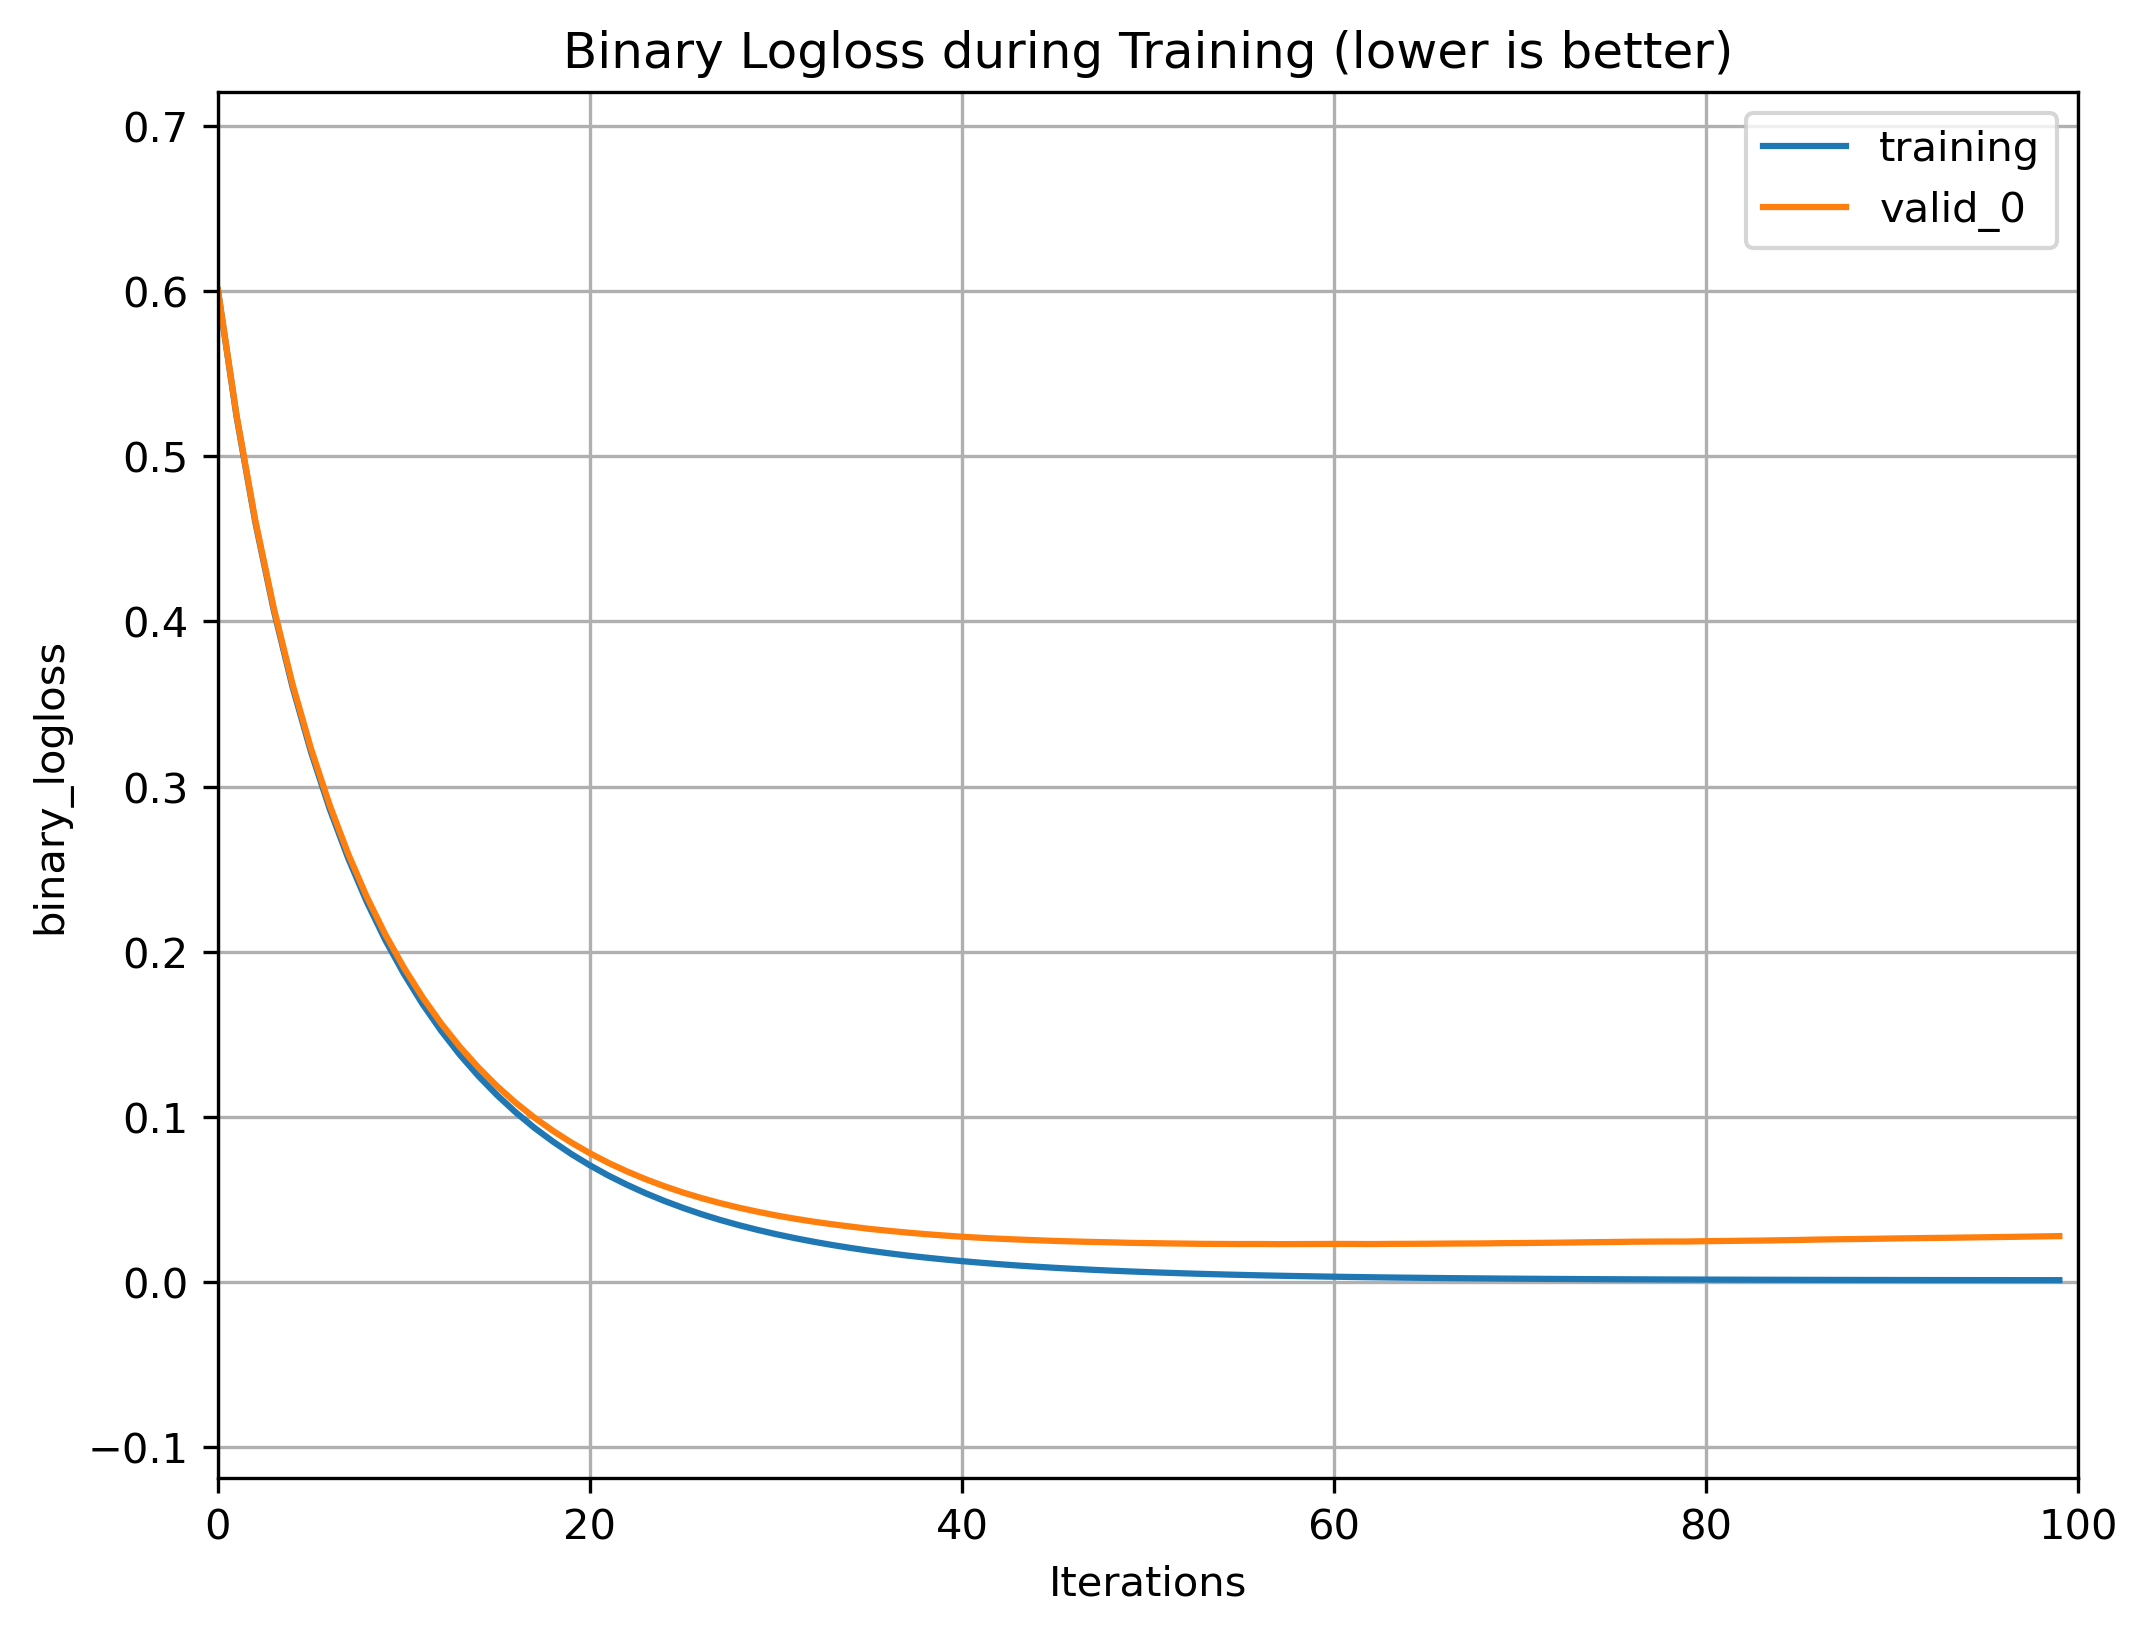

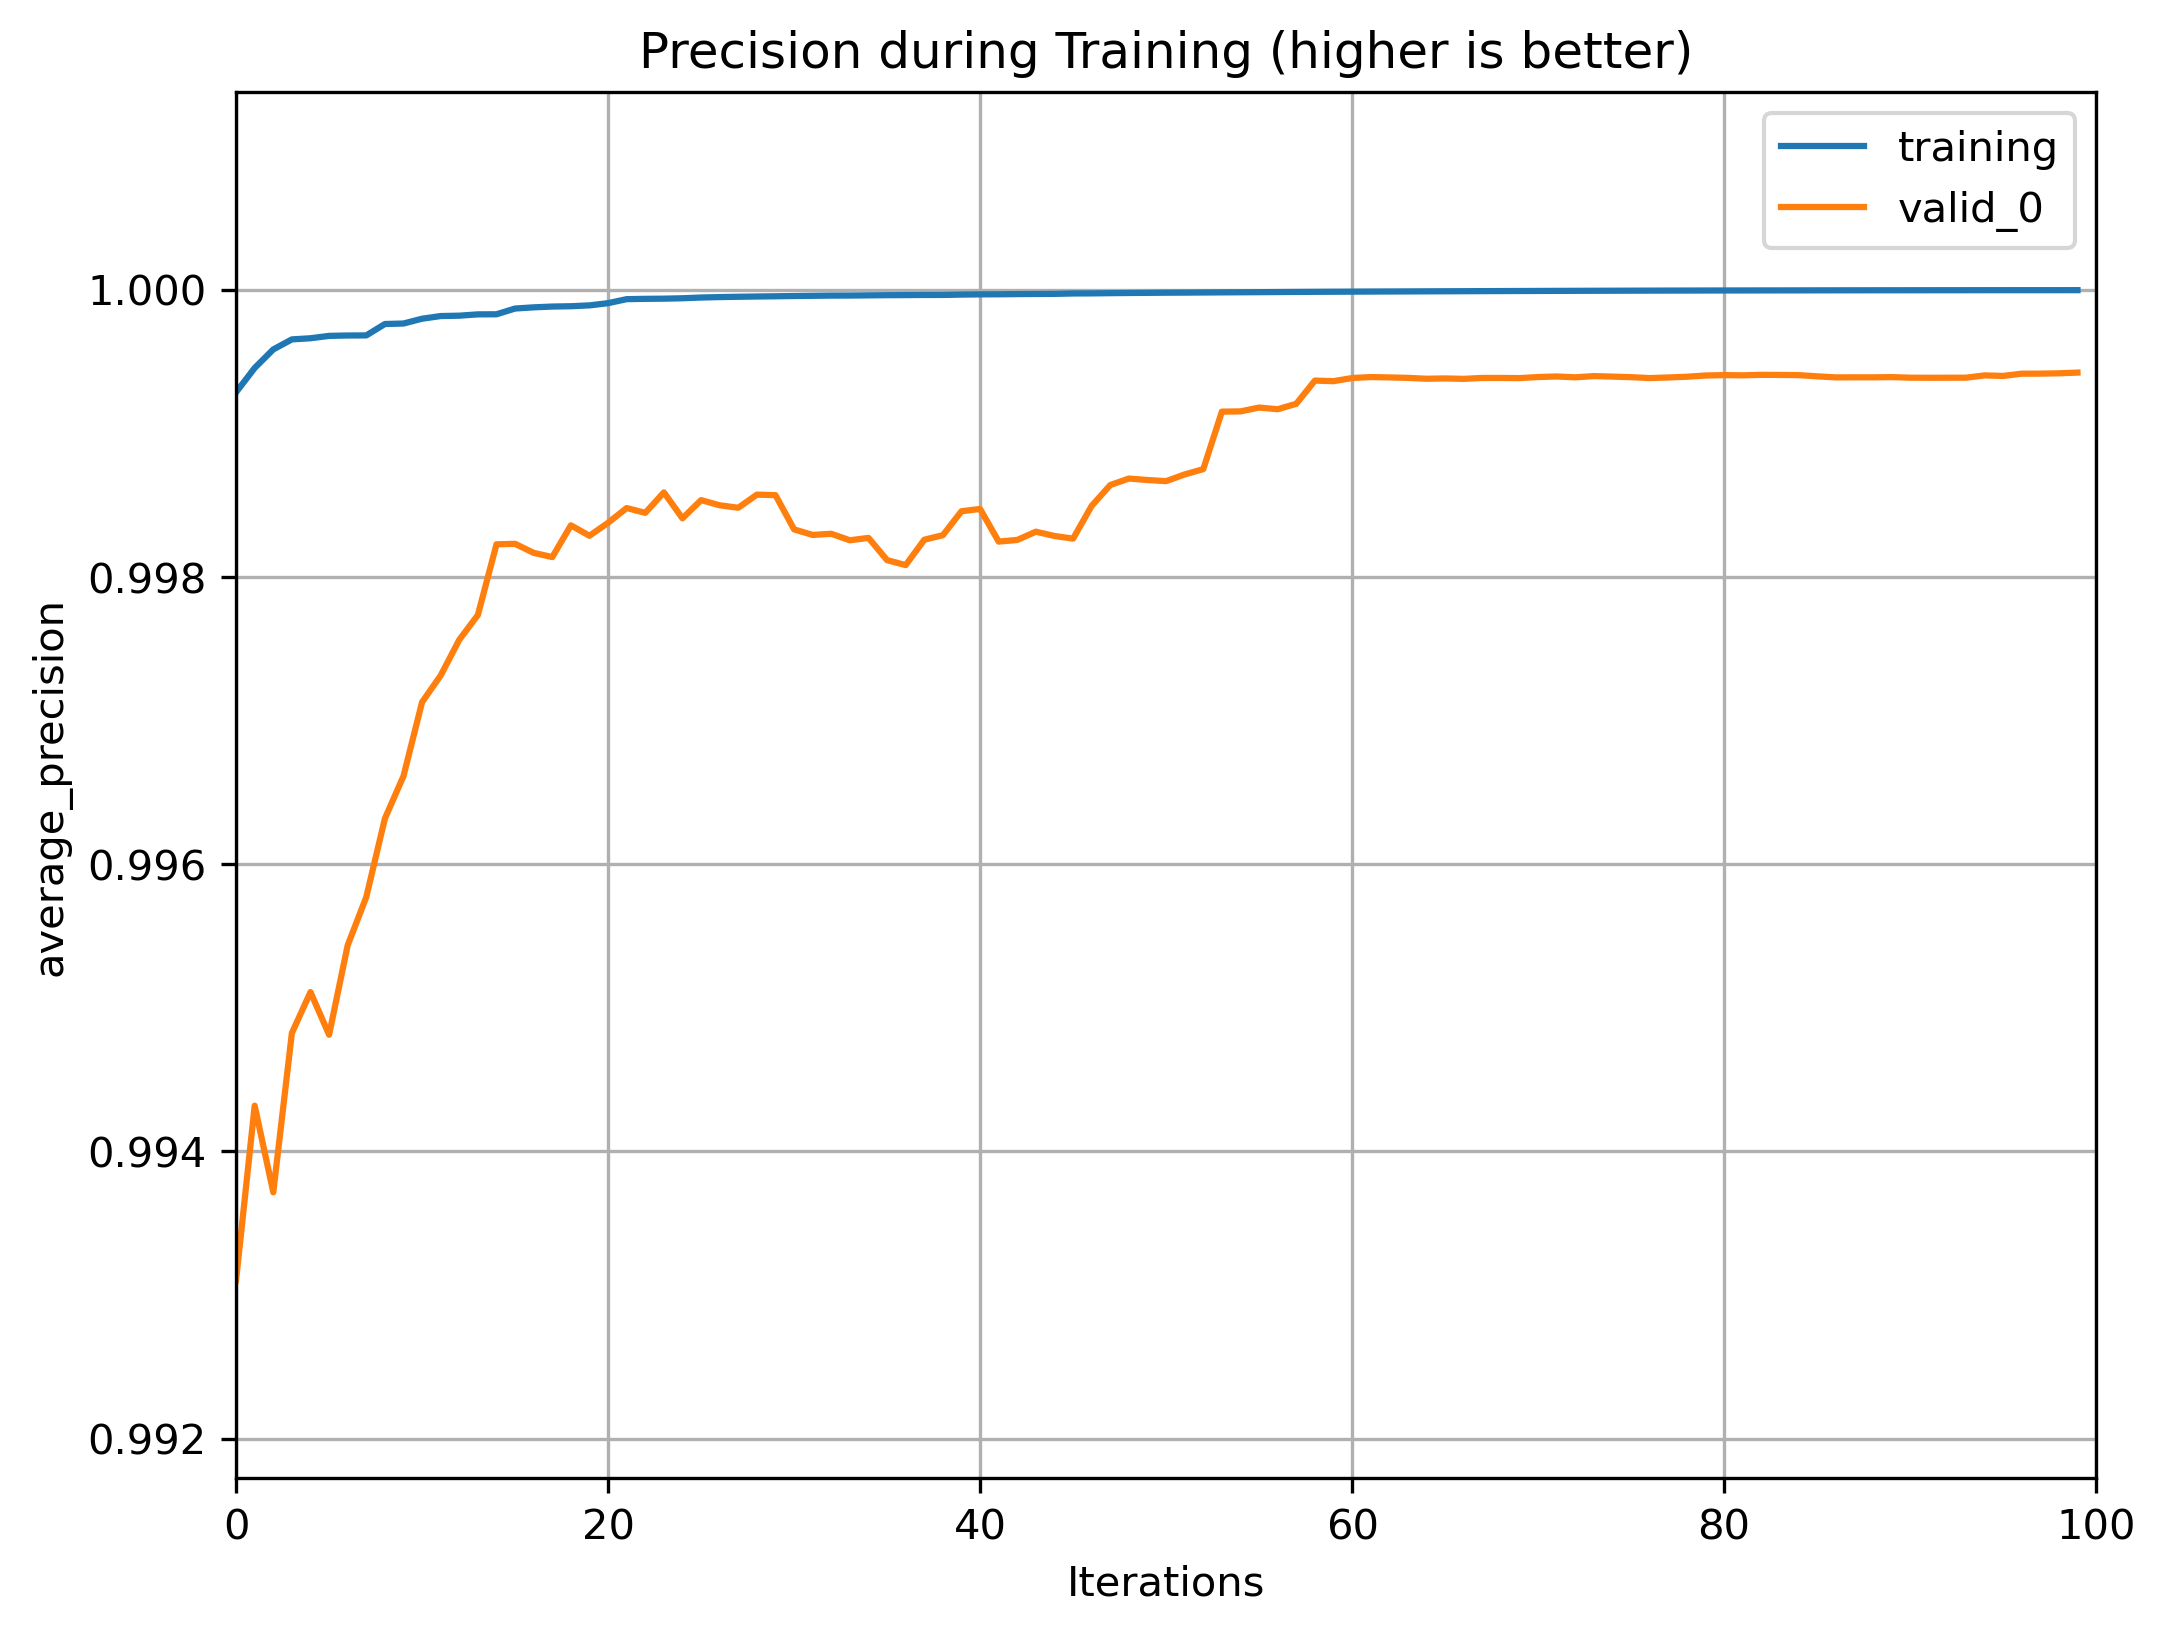

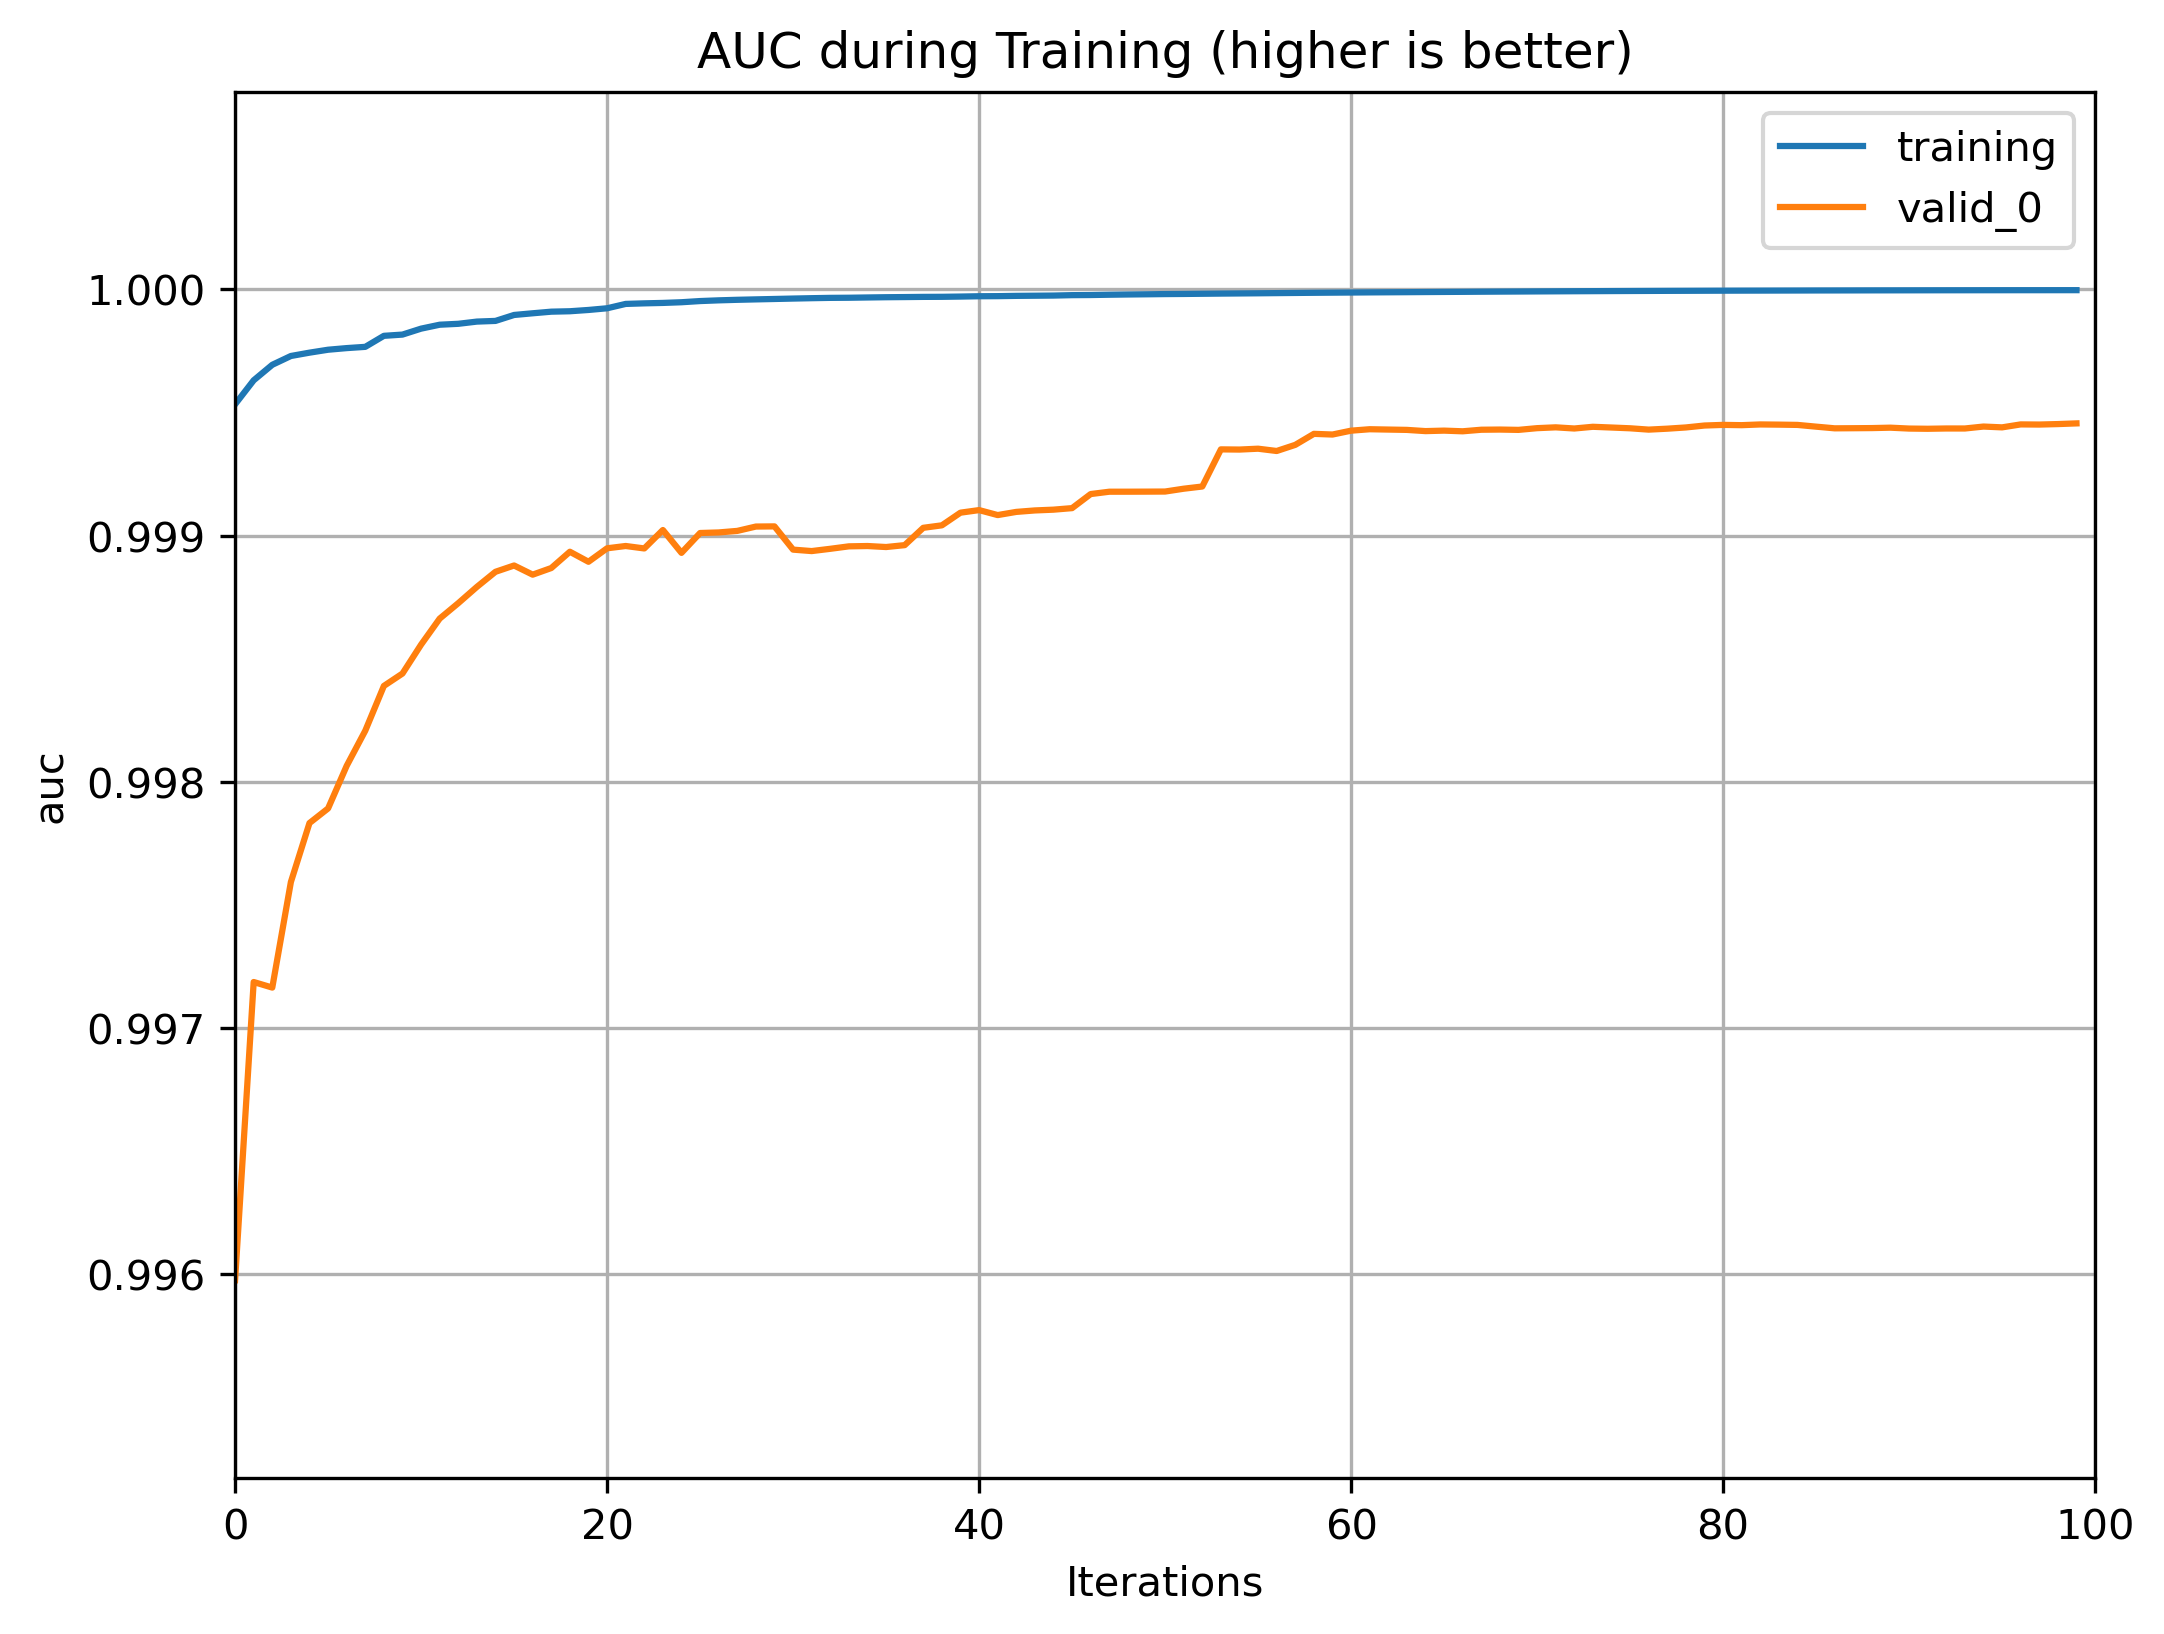

In [11]:
lightgbm.plot_metric(tb_lgbm, metric='binary_logloss', title='Binary Logloss during Training (lower is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_binary_logloss.png")
lightgbm.plot_metric(tb_lgbm, metric='average_precision', title='Precision during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_average_precision.png")
lightgbm.plot_metric(tb_lgbm, metric='auc', title='AUC during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_auc.png")

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

              precision    recall  f1-score   support

           0     0.9987    0.9909    0.9948     11530
           1     0.9910    0.9987    0.9948     11578

    accuracy                         0.9948     23108
   macro avg     0.9948    0.9948    0.9948     23108
weighted avg     0.9948    0.9948    0.9948     23108



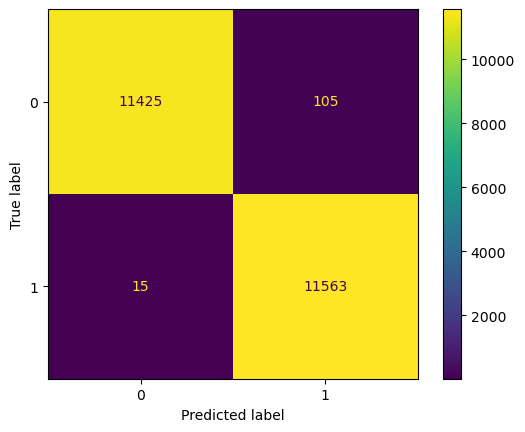

In [12]:
y_pred = tb_lgbm.predict(X_tb_validate)
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

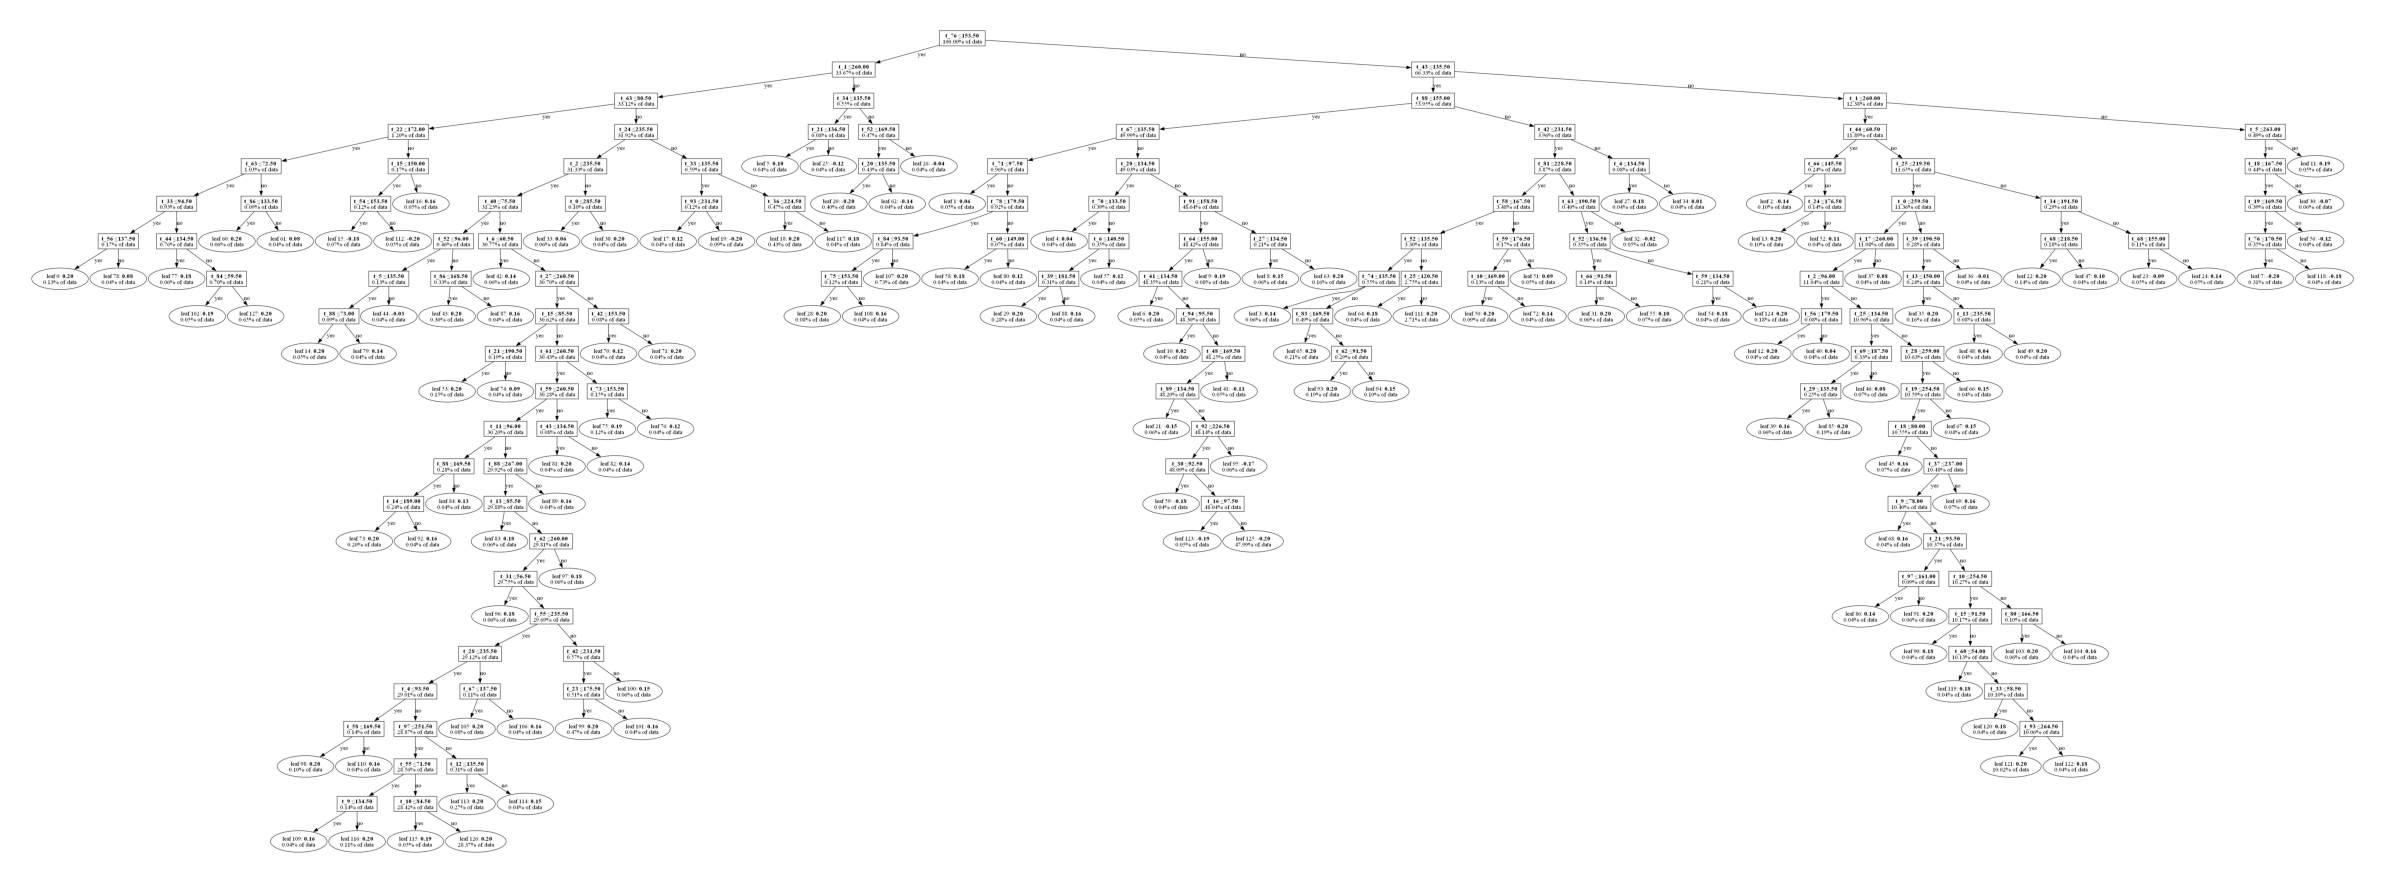

In [13]:
#One of the many layers of LGBM (1st layer)
lightgbm.plot_tree(tb_lgbm, figsize=(10,10), dpi=300, show_info='data_percentage', precision=2, orientation='vertical')
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_TB_tree.png")

## 2.3. Training on Instance-Based Behaviors

### 2.3.1. Training the Model

In [14]:
#Training Model
start_time()
ib_lgbm = setup_model(IB_HYPERPARAMS)
ib_lgbm.fit(X_ib_training, y_ib_training, eval_set=[(X_ib_validate, y_ib_validate), (X_ib_training, y_ib_training)], eval_metric=['binary_logloss', 'average_precision', 'auc'])
end_time("LGBM_IB")

#Saving Model as file
dump(ib_lgbm, "Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB.model")

[LightGBM] [Info] Number of positive: 26935, number of negative: 26983
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4068
[LightGBM] [Info] Number of data points in the train set: 53918, number of used features: 43
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1050 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 24 dense feature groups (1.23 MB) transferred to GPU in 0.004323 secs. 1 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 24 dense feature groups (0.53 MB) transferred to GPU in 0.003500 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 24 dense 

['Outputs/LGBM/TUNED_RYZEN_LGBM_IB.model']

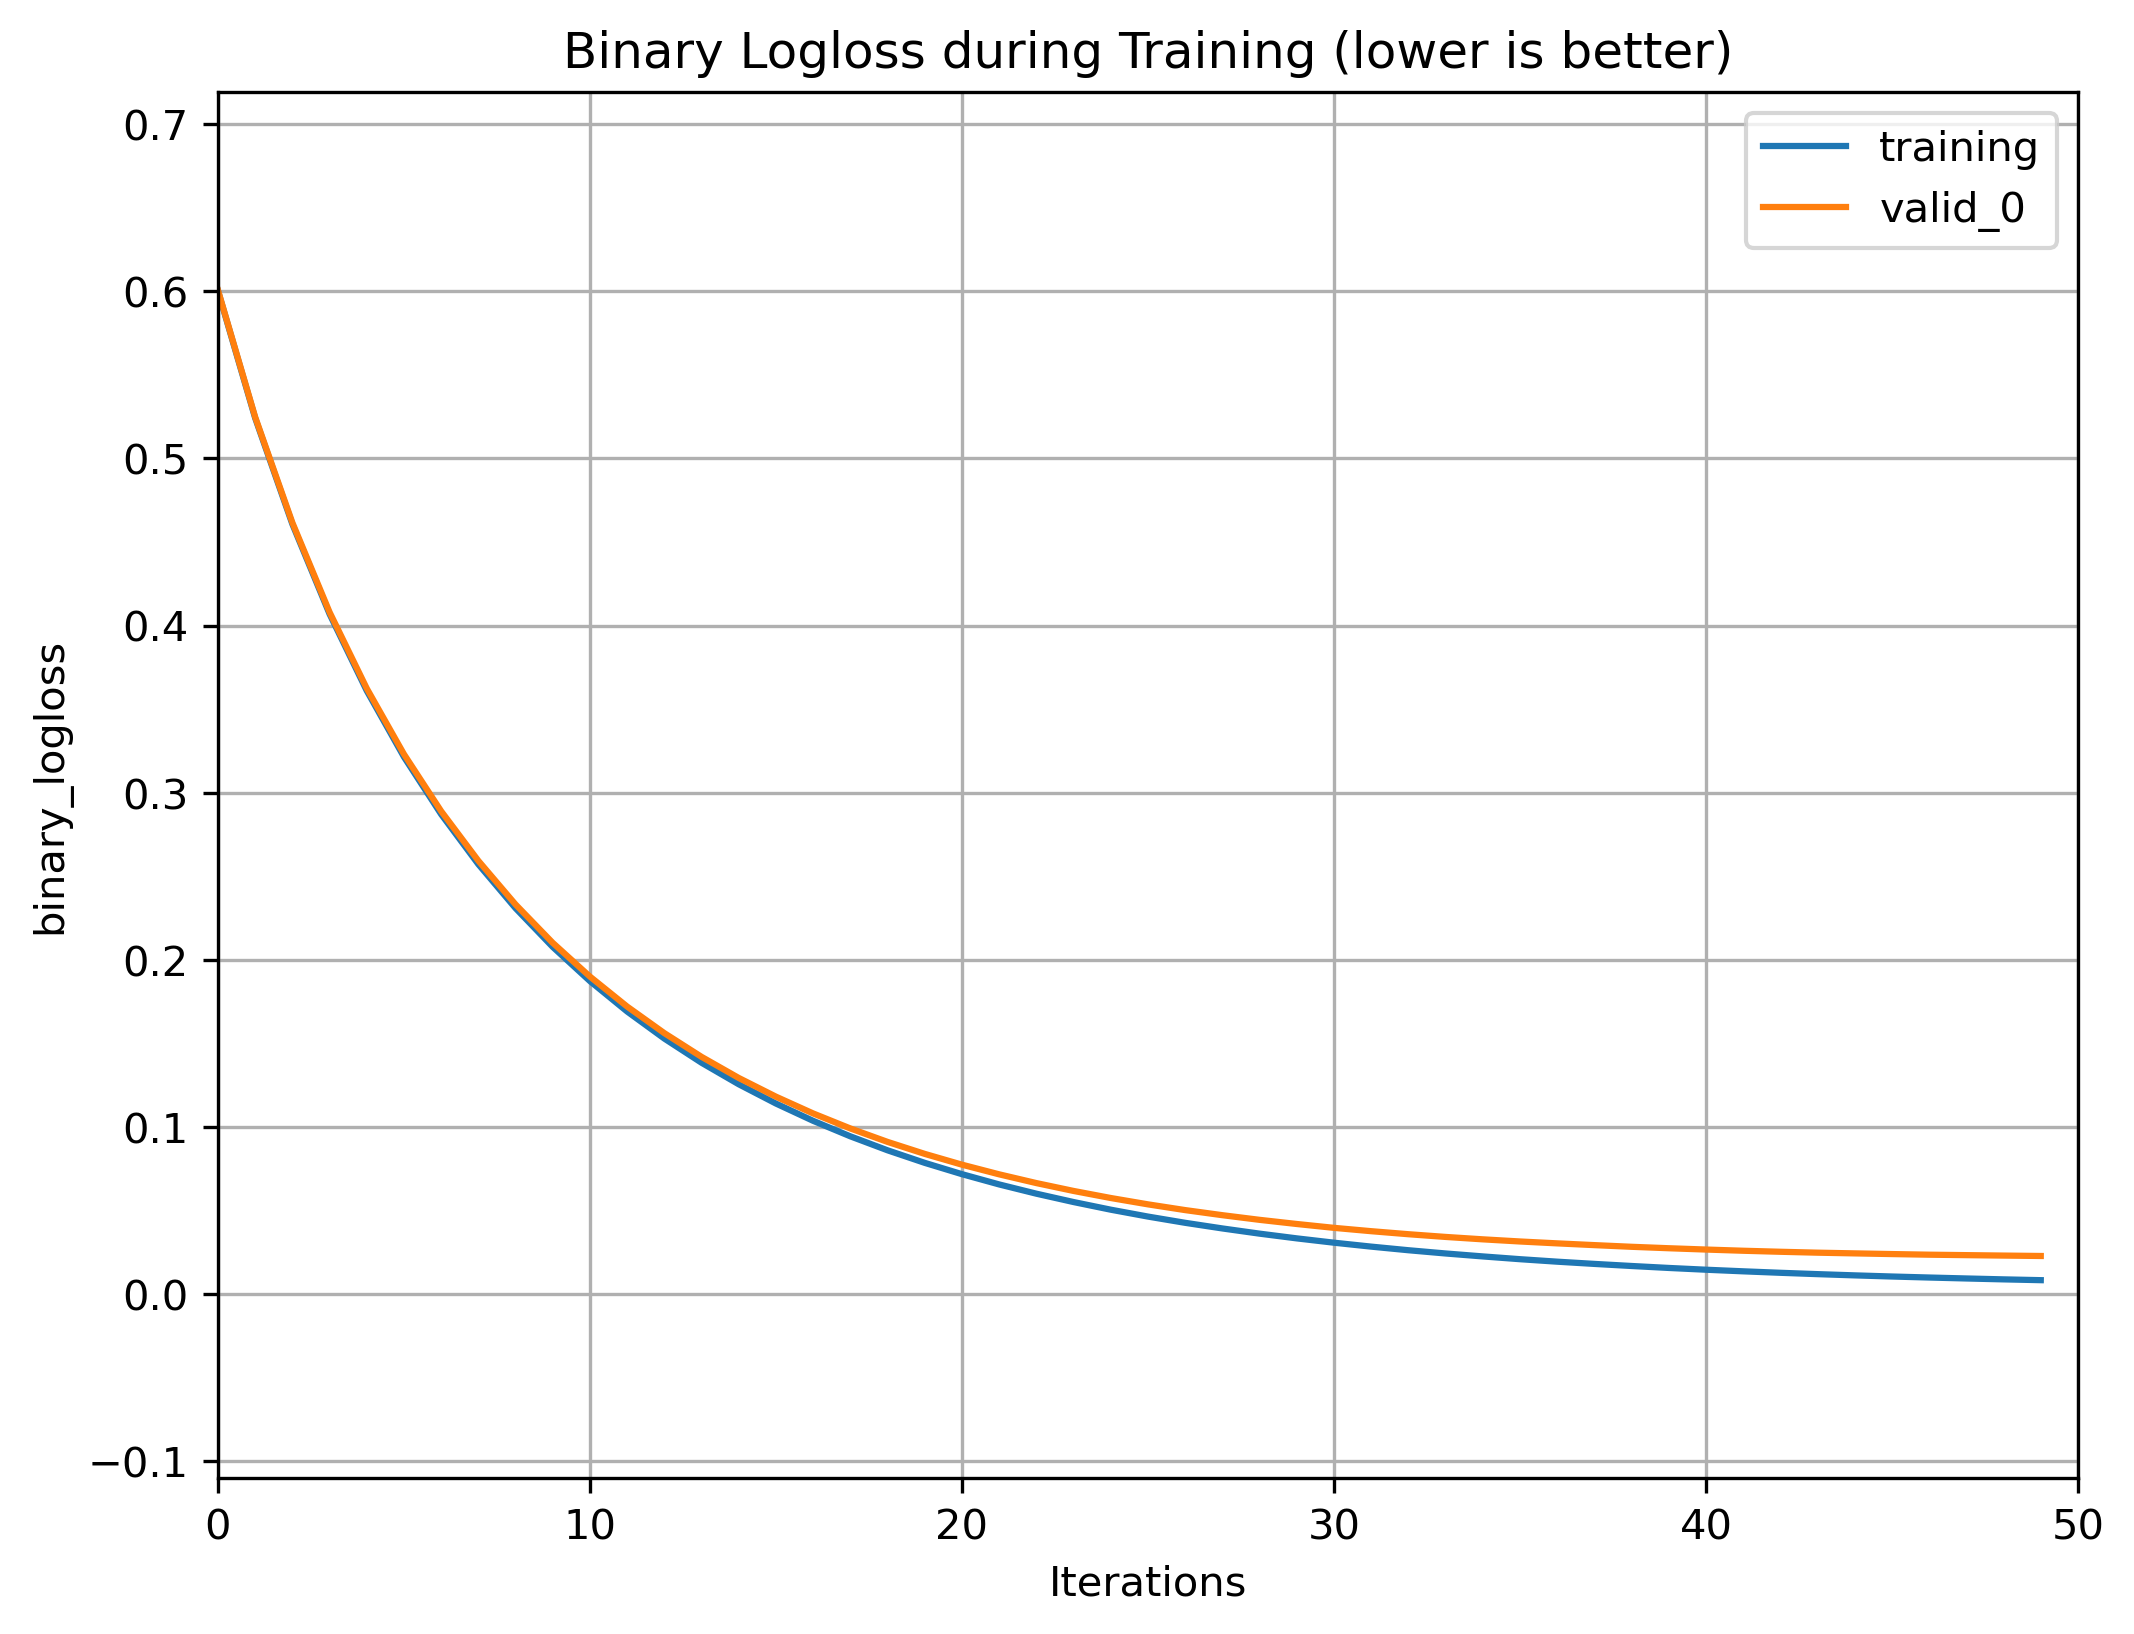

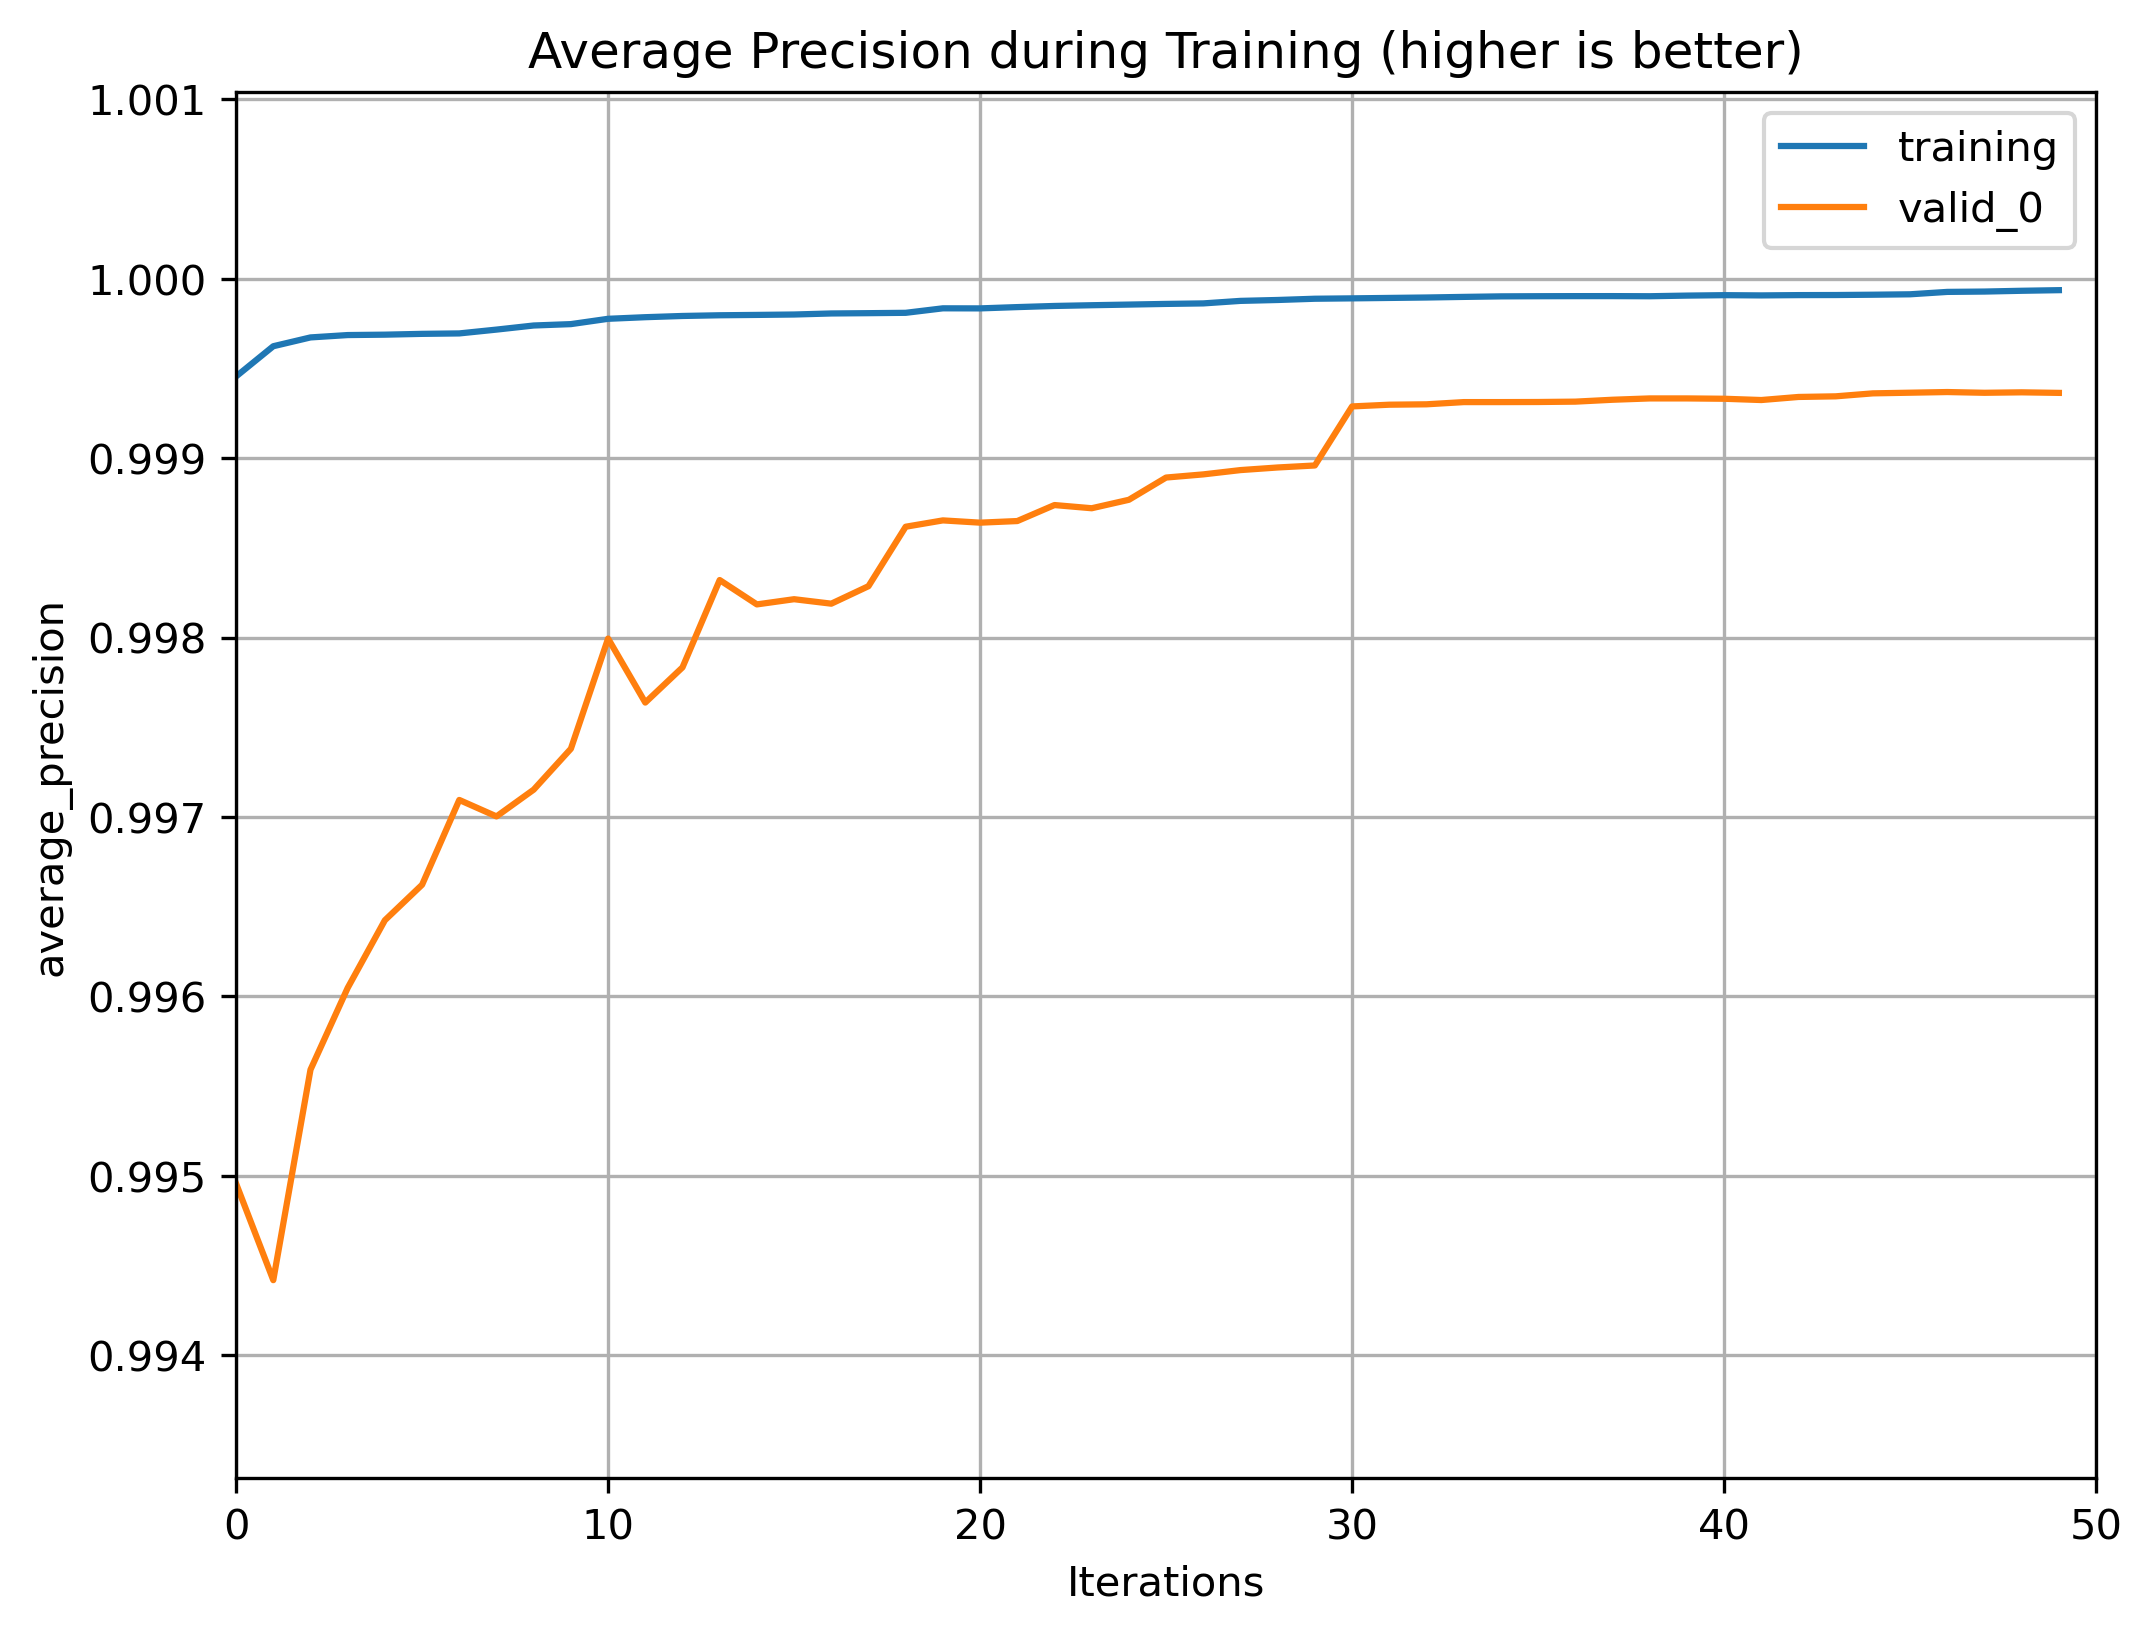

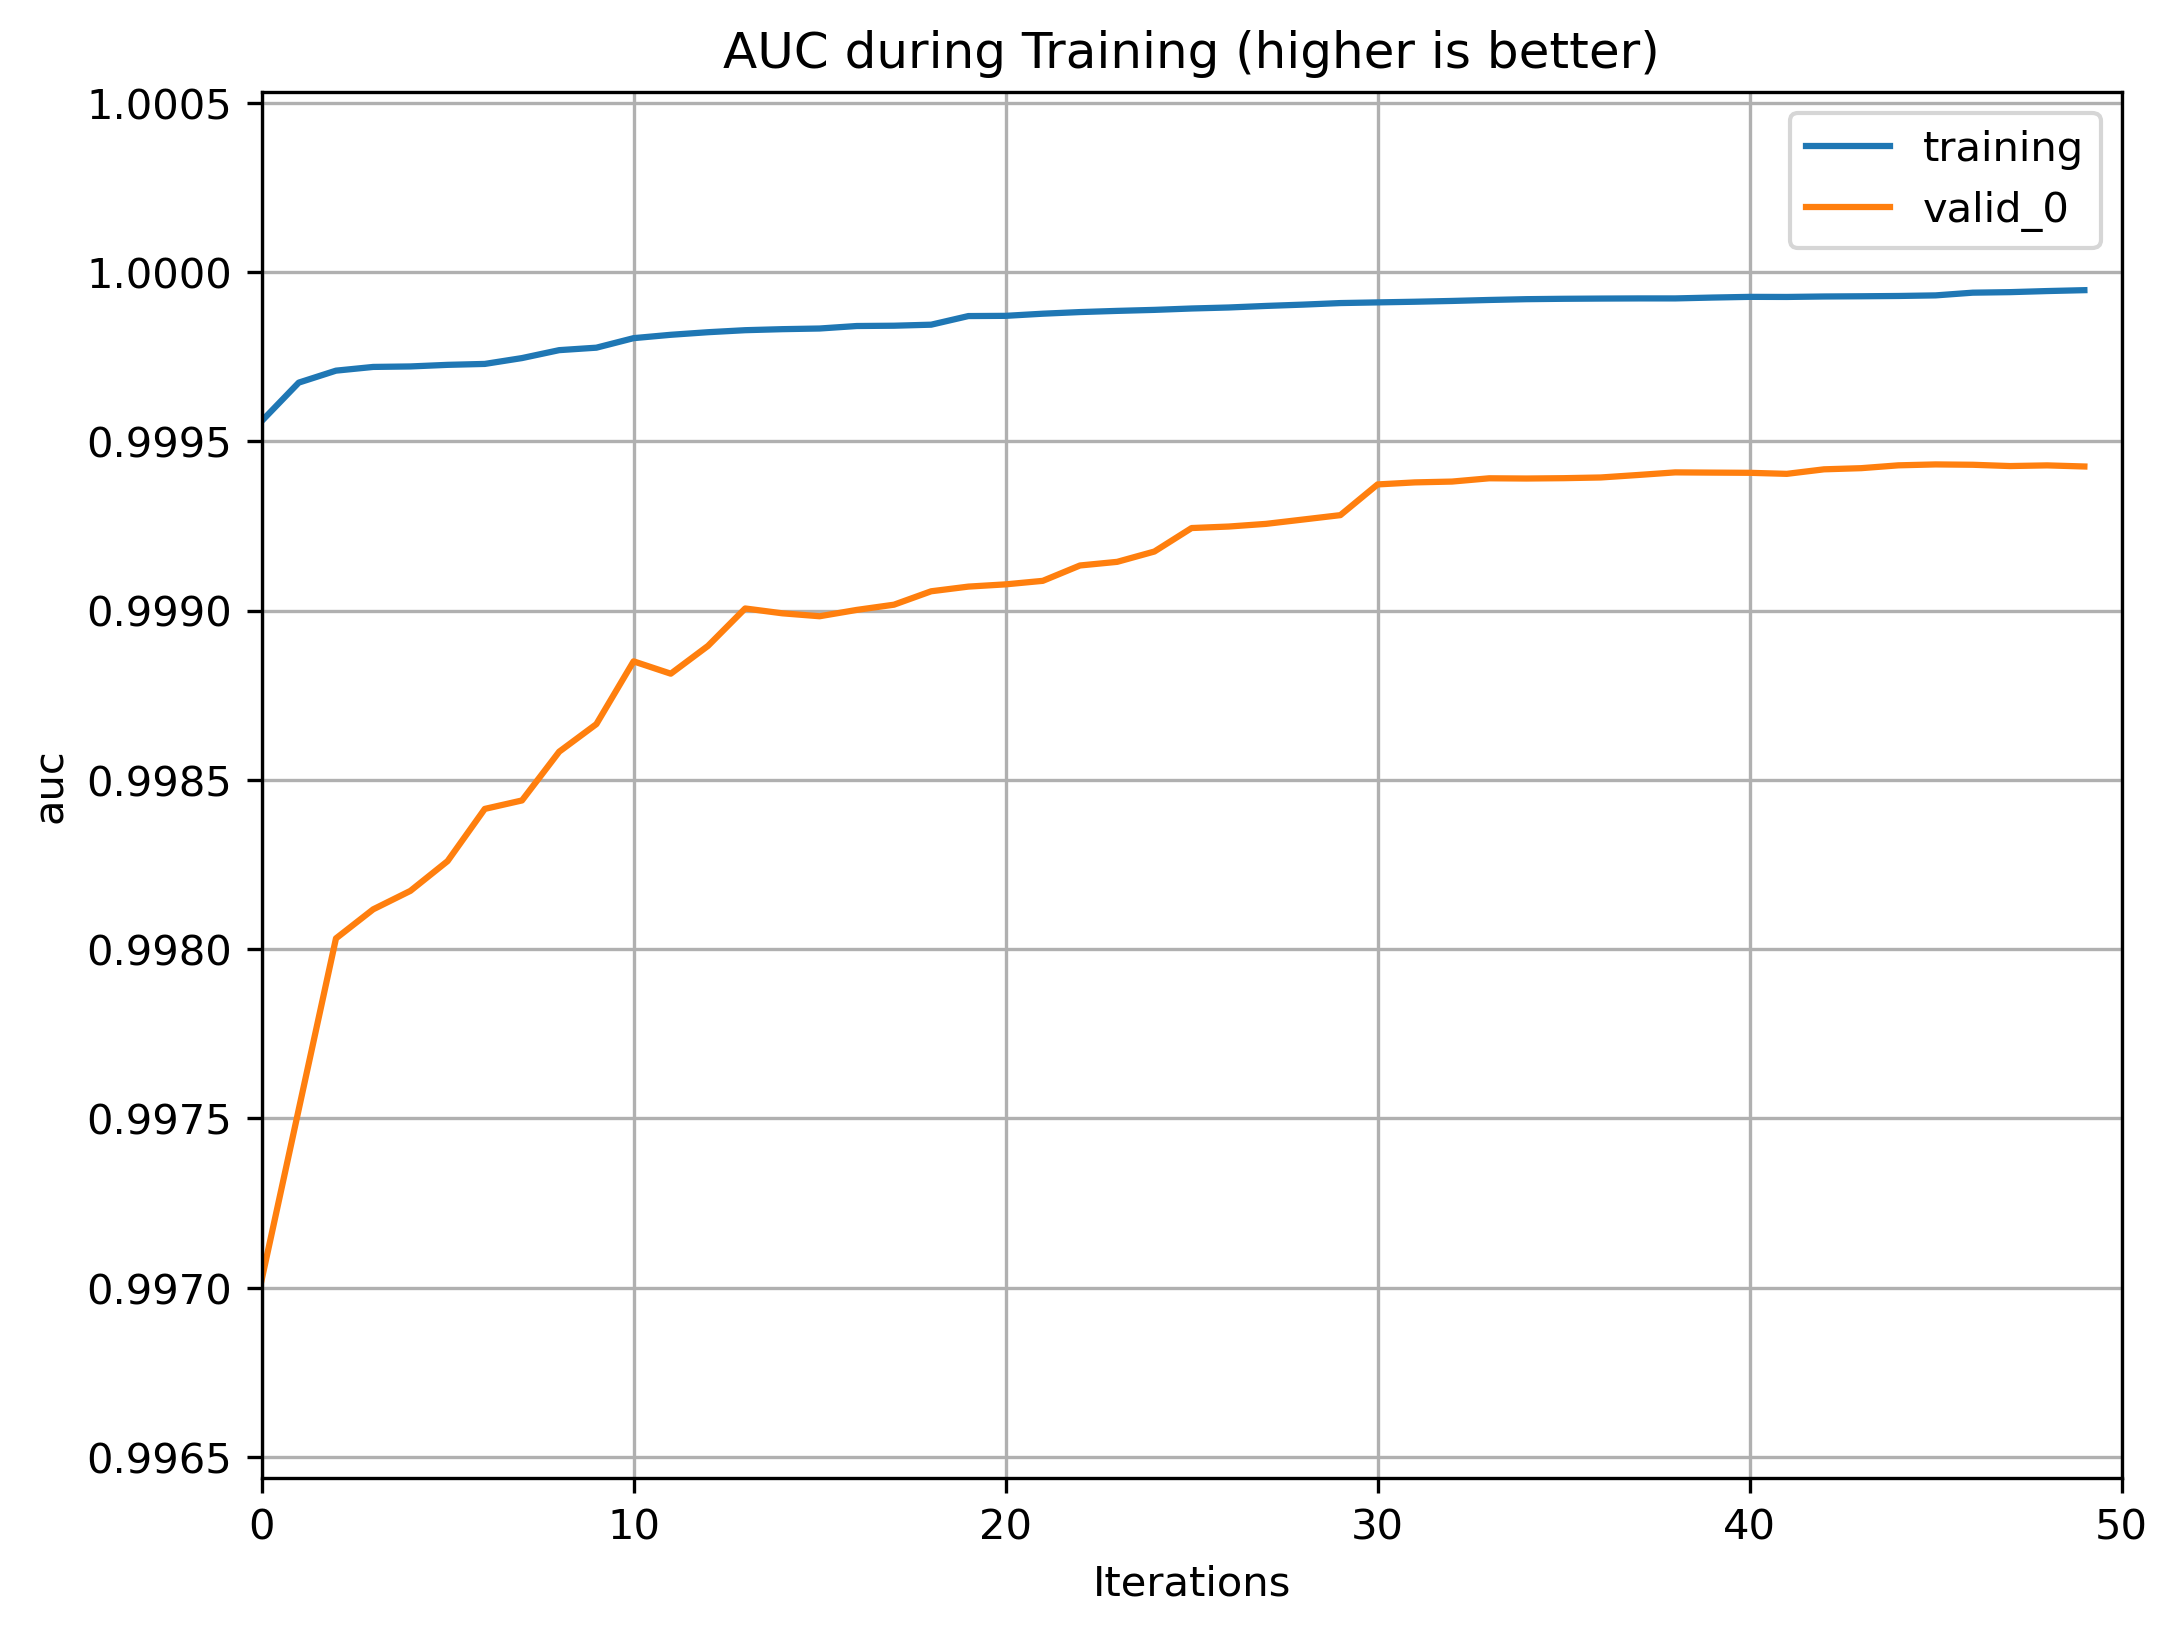

In [15]:
lightgbm.plot_metric(ib_lgbm, metric='binary_logloss', title='Binary Logloss during Training (lower is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_binary_logloss.png")
lightgbm.plot_metric(ib_lgbm, metric='average_precision', title='Average Precision during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_average_precision.png")
lightgbm.plot_metric(ib_lgbm, metric='auc', title='AUC during Training (higher is better)', figsize=(8,6), dpi=300)
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_auc.png")

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

              precision    recall  f1-score   support

           0     0.9979    0.9906    0.9943     11530
           1     0.9907    0.9979    0.9943     11578

    accuracy                         0.9943     23108
   macro avg     0.9943    0.9943    0.9943     23108
weighted avg     0.9943    0.9943    0.9943     23108



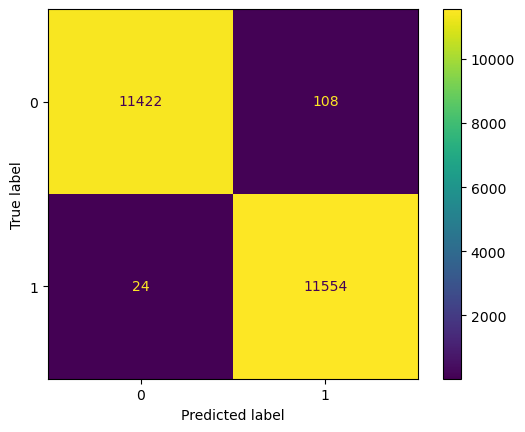

In [16]:
y_pred = ib_lgbm.predict(X_ib_validate)
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

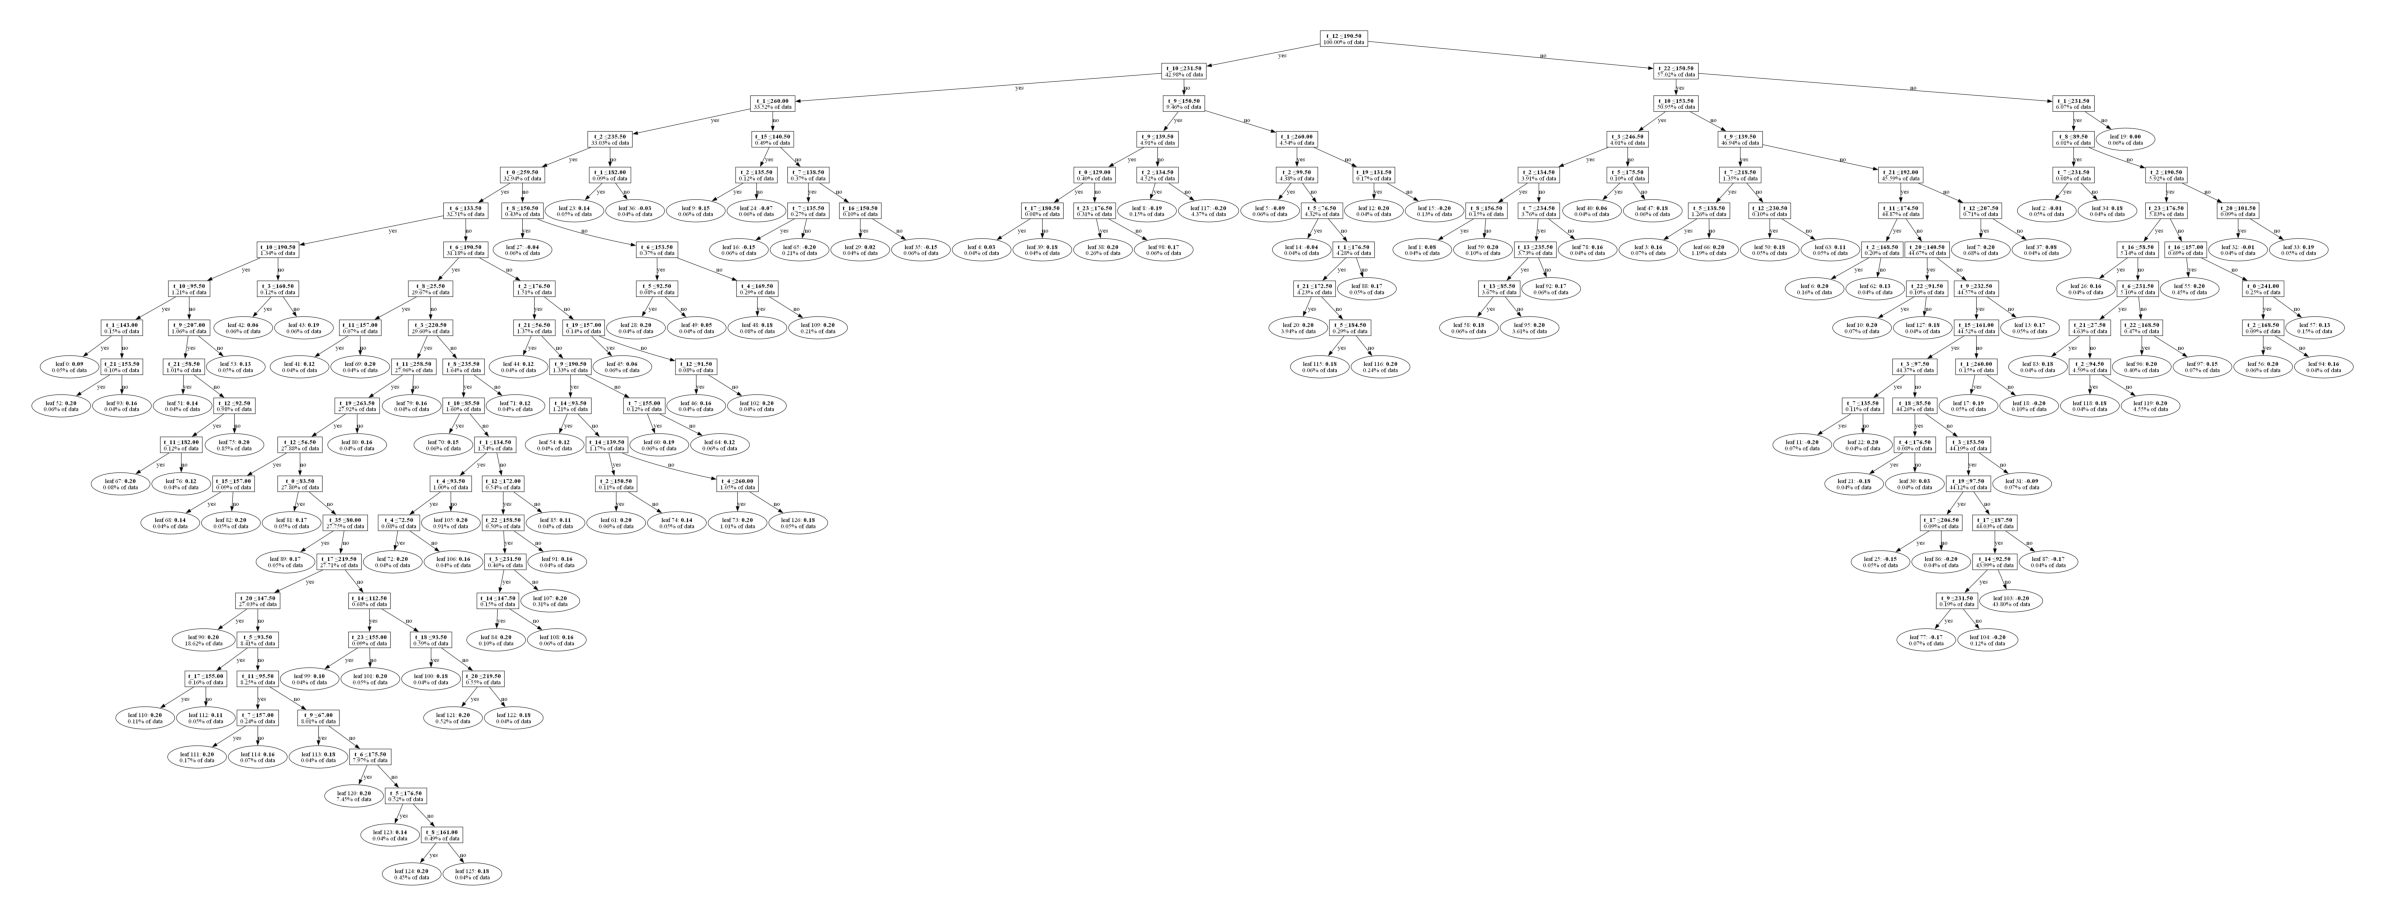

In [17]:
#One of the many layers of LGBM (1st layer)
lightgbm.plot_tree(ib_lgbm, figsize=(10,10), dpi=300, show_info='data_percentage', precision=2, orientation='vertical')
plt.savefig("Outputs/LGBM/"+MODEL_FILENAME+"_LGBM_IB_tree.png")

In [18]:
logging("\n")